## Project Proposal - ImageNicheNet

**Description**

The goal of the project is to create ImageNicheNet, a network for specialized image generation.

**Overview**

1. Create a method for measuring the quality of images. The method should:
    1. Be able to take a prompt and a set of images and score how good the images are in response to the prompt.
    2. Be compatible to use with several different categories such as: realistic, animated, artistic styles.
    3. Should not be weak to adversarial attacks, meaning that it shouldn’t be possible to optimize images using the same reward method in order to score better. More details about this will be discussed over a call.
    4. Be simple to use.
2. Create prompt generation method for the following categories: realistic, animated, artistic
3. Integrate the reward mechanism into the NicheNet-validator code: https://github.com/NicheTensor/nichenet-validator

# Text to Image Rewarding using Mixture of Experts
This notebook cover 2 key problem:
1. Implementing a simple but efficient module for Evaluating Text To Image (T2I) Model
2. Validate performance of this Rewarding Module by mimicking the process in production
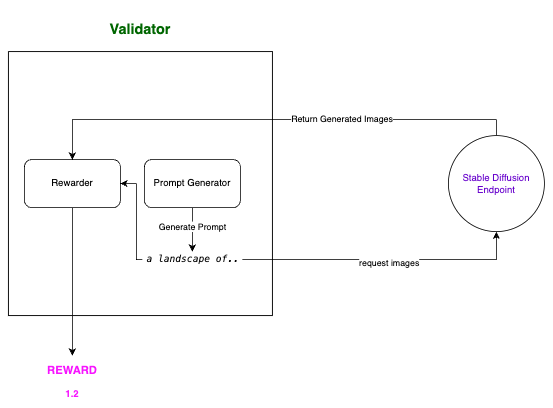

**Rewarding Module**

To rewarding a pair of prompt-images, we accumulate score from many SOTA in Text To Image Assessment:
- ImageReward: Learning and Evaluating Human Preferences for Text-to-Image Generation `[-2, 2]`
[code](https://github.com/THUDM/ImageReward) [paper](https://arxiv.org/abs/2304.05977)

- Human Preference Score v2: A Solid Benchmark for Evaluating Human Preferences of Text-to-Image Synthesis `[0, 1]` [code](https://github.com/tgxs002/HPSv2) [paper](https://arxiv.org/abs/2306.09341)
- Pick-a-pic score `[0, 8]` [code](https://huggingface.co/yuvalkirstain/PickScore_v1)

- Image Aesthetic Score `[0, 1]` [code](https://github.com/christophschuhmann/improved-aesthetic-predictor)

The final reward is computed as: `reward = image_reward + hpsv2*0.1 + pick_a_pic*0.1 + aesthetic*0.0125`

**Prompter Module**

Provided topics, such as `artiristic style, animated style`, we use 2 LLM model for generate high quality, aesthetic prompt:
- [Magic Prompt](https://huggingface.co/Gustavosta/MagicPrompt-Stable-Diffusion) for generate main object, content (set `max_length=28`)
- [Fooocus Prompt Expansion](https://github.com/lllyasviel/Fooocus/discussions/117#raw) for continue complete prompt for better aesthetic (set `max_length=64`)

For example: 
1. Initial prompt: `a landscape of`
2. Output of Magic Prompt: `a landscape of a beautiful mountain with a lake`
3. Output of Fooocus - Final Prompt: `a landscape of a beautiful mountain with a lake, high quality, very detailed, cinematic, symbolic, mystical, dramatic, sharp focus, surreal, open background`

**Implementation** https://github.com/toilaluan/ig-rewarding

## Getting Started
In this session, we show how to use our rewarder.

In [1]:
# clone this repository
!git clone https://github.com/toilaluan/ig-rewarding.git

Cloning into 'ig-rewarding'...


remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 240 (delta 105), reused 187 (delta 65), pack-reused 0
Receiving objects: 100% (240/240), 2.92 MiB | 8.40 MiB/s, done.
Resolving deltas: 100% (105/105), done.
Filtering content: 100% (6/6), 59.36 MiB | 36.77 MiB/s, done.


In [2]:
%cd ig-rewarding/

/root/edward/stablediffusion/ig-rewarding/notebooks/ig-rewarding


Install requirements, make sure that you updated `transformers`, `datasets`, `accelerate`, `diffusers`

In [3]:
!pip install -r requirements.txt --quiet

In [4]:
!pip install -U transformers datasets accelerate --quiet

### Init the Validator

In [5]:
from ig_rewarding import Validator
import yaml
config_file = "ig_rewarding/config/baseline.yaml"
with open(config_file, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

/root/miniconda3/envs/luan_tt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
validator = Validator(config["rewarder"], config["prompter"])

File downloaded and saved to cache: sac+logos+ava1-l14-linearMSE.pth
load checkpoint from /root/.cache/ImageReward/ImageReward.pt


INFO:root:Loaded ViT-H-14 model config.


checkpoint loaded


INFO:root:Loading pretrained ViT-H-14 weights (laion2B-s32B-b79K).


Downloading: "https://huggingface.co/lllyasviel/misc/resolve/main/fooocus_expansion.bin" to /root/edward/stablediffusion/ig-rewarding/notebooks/ig-rewarding/ig_rewarding/models/prompt_expansion/fooocus_expansion/pytorch_model.bin



100%|██████████| 335M/335M [00:03<00:00, 91.0MB/s] 


Fooocus V2 Expansion: Vocab with 642 words.


### Generate prompt based on topic using `validator.prompter`

We use [ChromaDB](https://www.trychroma.com/), [Sentence Transfromers](https://www.sbert.net/) to store prompts database [THUDM/ImageRewardDB](https://huggingface.co/datasets/THUDM/ImageRewardDB), then retrieve top k similar prompts based on provided topic.

In [7]:
topics = ["a landscape image of", "a animated image of"]
prompts = validator.generate_prompt(topics, n_prompts=2)
for topic, prompt_set in zip(topics, prompts):
  print('-'*10)
  print(topic)
  print(prompt_set)

['a landscape image of what looks like a skull and a robot king with red and white king tribal masks stands in the rainforest, concept art', 'a landscape image of a gas station with a sakura tree and kimono on it. Fields on the sides of the plaza and hills']


100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


['a landscape image of what looks like a skull and a robot king with red and white king tribal masks stands in the rainforest, concept art, very detailed, cinematic, symbolic, mystical, dramatic, sharp focus, surreal, open background, dynamic composition, highly intricate, atmosphere, light, fine detail, shiny, divine, sacred, perfect, calm, unique, awesome', 'a landscape image of a gas station with a sakura tree and kimono on it. Fields on the sides of the plaza and hills, sharp detail, warm colors, light, cinematic, scenic, detailed, color, intricate, elegant, professional, artistic, extremely, highly coherent, colorful, epic, stunning, full, beautiful, dramatic, illuminated, best, inspired']
['a animated image of anthropomorphic sloth running away from a flock of black chickens, concept art from lifelike, animated, highly detailed', 'a animated image of a baby elephant. the baby elephant is in the middle of a forest. there is a rocket. stunning fantasy art by']


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

['a animated image of anthropomorphic sloth running away from a flock of black chickens, concept art from lifelike, animated, highly detailed, magic, perfect, colorful, vivid, beautiful, inspired, pretty, amazing, cinematic, stunning, creative, best, fair, innocent, pure, sharp, determined, inspiring, cute, fine detail, light, dynamic, vibrant', 'a animated image of a baby elephant. the baby elephant is in the middle of a forest. there is a rocket. stunning fantasy art by, inspired, highly detailed, cinematic, saturated colors, dynamic background, beautiful, epic, shining, sharp focus, winning, vivid, best, artistic, dramatic, aesthetic, very inspirational, innocent, inspiring, creative, pretty, color']
----------
a landscape image of
['a landscape image of what looks like a skull and a robot king with red and white king tribal masks stands in the rainforest, concept art, very detailed, cinematic, symbolic, mystical, dramatic, sharp focus, surreal, open background, dynamic composition,

### Init a Stable Diffusion Model as a miner

We examine the process of validating by use Validator to generate a prompt about *landscape* then request a Stable Diffusion model to generate 4 images.

This pair of prompt-images will be feed to Validator for calculating the reward.

In [8]:
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.to("cuda")
pipe.enable_sequential_cpu_offload()

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.03it/s]


Visualize generated images

In [9]:
images = []
for i in range(4):
  image = pipe(prompts[0][0], num_images_per_prompt=1).images[0]
  images.append(image)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:20<00:00,  2.40it/s]


a landscape image of what looks like a skull and a robot king with red and white king tribal masks stands in the rainforest, concept art, very detailed, cinematic, symbolic, mystical, dramatic, sharp focus, surreal, open background, dynamic composition, highly intricate, atmosphere, light, fine detail, shiny, divine, sacred, perfect, calm, unique, awesome


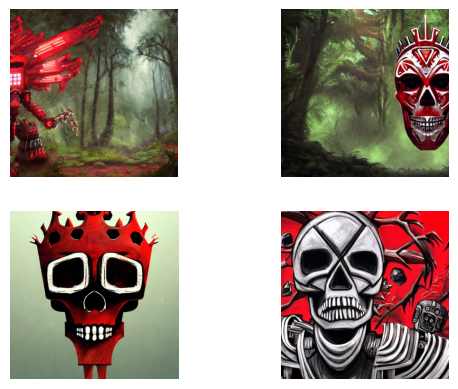

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

rows = 2
columns = 2
print(prompts[0][0])
fig = plt.figure()

for i in range(1, len(images) + 1):
    img = images[i - 1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Calculate the reward

`averaged_reward` is weighted sum of all reward models

`component_rewards` is a dict of reward by each model

In [11]:
averaged_reward, component_rewards = validator.get_reward_score(images, prompts[0][0])
print(averaged_reward)
print(component_rewards)

-0.18773657083511353
{'clip_aesthetic_rewarder': 5.8937907218933105, 'pick_rewarder': 0.17825105786323547, 'image_rewarder': -0.3056989014148712, 'hps_v2_rewarder': 0.2646484375}


## Analyze Rewarder Performance by mimicking the process
We perform topic-wise Text To Image generation to synthentic dataset.

**Topics**:
- animated style
- artistic style
- landscape style
- painting style
- portrait style
- realistic photo style

**T2I model Candidates - Fake Miners**:
- dreamlike-art/dreamlike-photoreal-2.0
- rev-anim
- realistic-vision-v51
- edge-of-realism
- stabilityai/stable-diffusion-2-1
- CompVis/stable-diffusion-v1-4
- runwayml/stable-diffusion-v1-5
- segmind/SSD-1B
- stabilityai/stable-diffusion-xl-base-1.0

### Generate synthentic dataset to mimic the miners
For each SD/SDXL model (fake miner), we request 100 prompts for each topic, the SD/SDXL model will return 4 images for each prompt. So each SD/SDXL model will generate total `4*100*number_of_topics`.

The synthentic dataset already generated. See [toilaluan/tuned_prompt_ig_db_v1](https://huggingface.co/datasets/toilaluan/tuned_prompt_ig_db_v1)
### Calculate reward of fake miners
Each group of miner & topic has 100 pair of prompt-images, we feed each pair to the reward model to get the reward.

To get the final reward of a miner on a topic, we average all 100 rewards.

The reward, computed from above dataset, is already done. See [toilaluan/reward_tuned_prompt_v1](https://huggingface.co/datasets/toilaluan/reward_tuned_prompt_v1)

In [17]:
from datasets import load_dataset
reward_repo_name = "toilaluan/reward_tuned_prompt_v2"
ds = load_dataset(reward_repo_name, download_mode="force_redownload")
ds = ds['train'].to_pandas()
ds.model_type = ds.model_type.apply(lambda x: x.split("/")[-1])
ds.head()

Generating train split: 100%|██████████| 4500/4500 [00:00<00:00, 715371.74 examples/s]


,model_type,request_id,topic,reward,individual_rewards
0,stable-diffusion-v1-4,0,animated_style,1.482213,"{'clip_aesthetic_rewarder': 5.529629707336426,..."
1,stable-diffusion-v1-4,0,artistic_style,0.124475,"{'clip_aesthetic_rewarder': 6.465510845184326,..."
2,stable-diffusion-v1-4,0,landscape_style,0.723077,"{'clip_aesthetic_rewarder': 6.708657264709473,..."
3,stable-diffusion-v1-4,0,portrait_style,0.846680,"{'clip_aesthetic_rewarder': 6.558375358581543,..."
4,stable-diffusion-v1-4,0,realistic_photo_style,1.094817,"{'clip_aesthetic_rewarder': 6.396763324737549,..."


### Weighted Sum Reward comparision

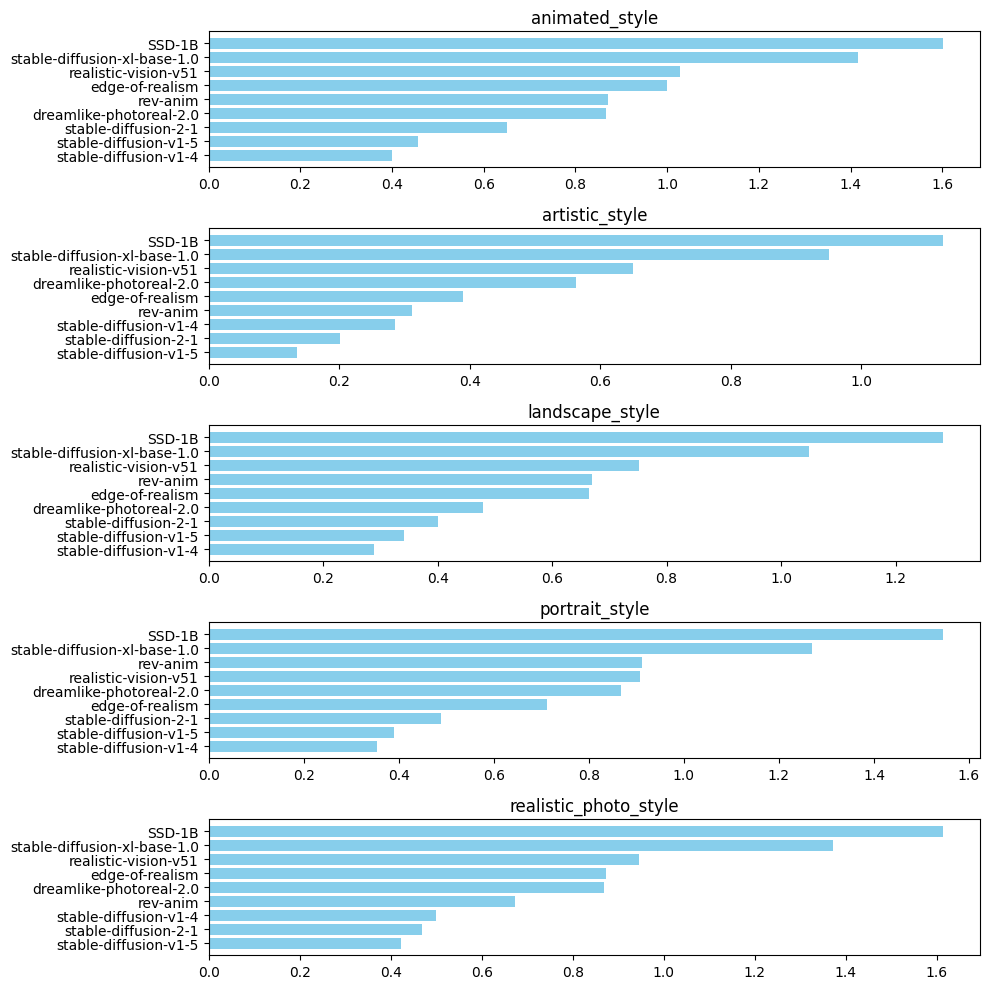

In [18]:
import matplotlib.pyplot as plt
num_topics = len(ds['topic'].unique())

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_topics, figsize=(10, 10), sharex=False)
for j, topic_name in enumerate(ds['topic'].unique()):
    model_reward = {}
    for model_name, model_grp in ds[ds['topic'] == topic_name].groupby('model_type'):
        model_reward[model_name] = model_grp.reward.mean()
    sorted_data = dict(sorted(model_reward.items(), key=lambda item: item[1]))

    # Extract names and values for plotting
    names = list(sorted_data.keys())
    values = list(sorted_data.values())

    # Create a bar plot in the specified subplot
    axes[j].barh(names, values, color=['skyblue'])
    axes[j].set_title(topic_name)

# Adjust layout and spacing between subplots
plt.tight_layout()

# Display the combined figure
plt.show()


### Individual Reward Comparision

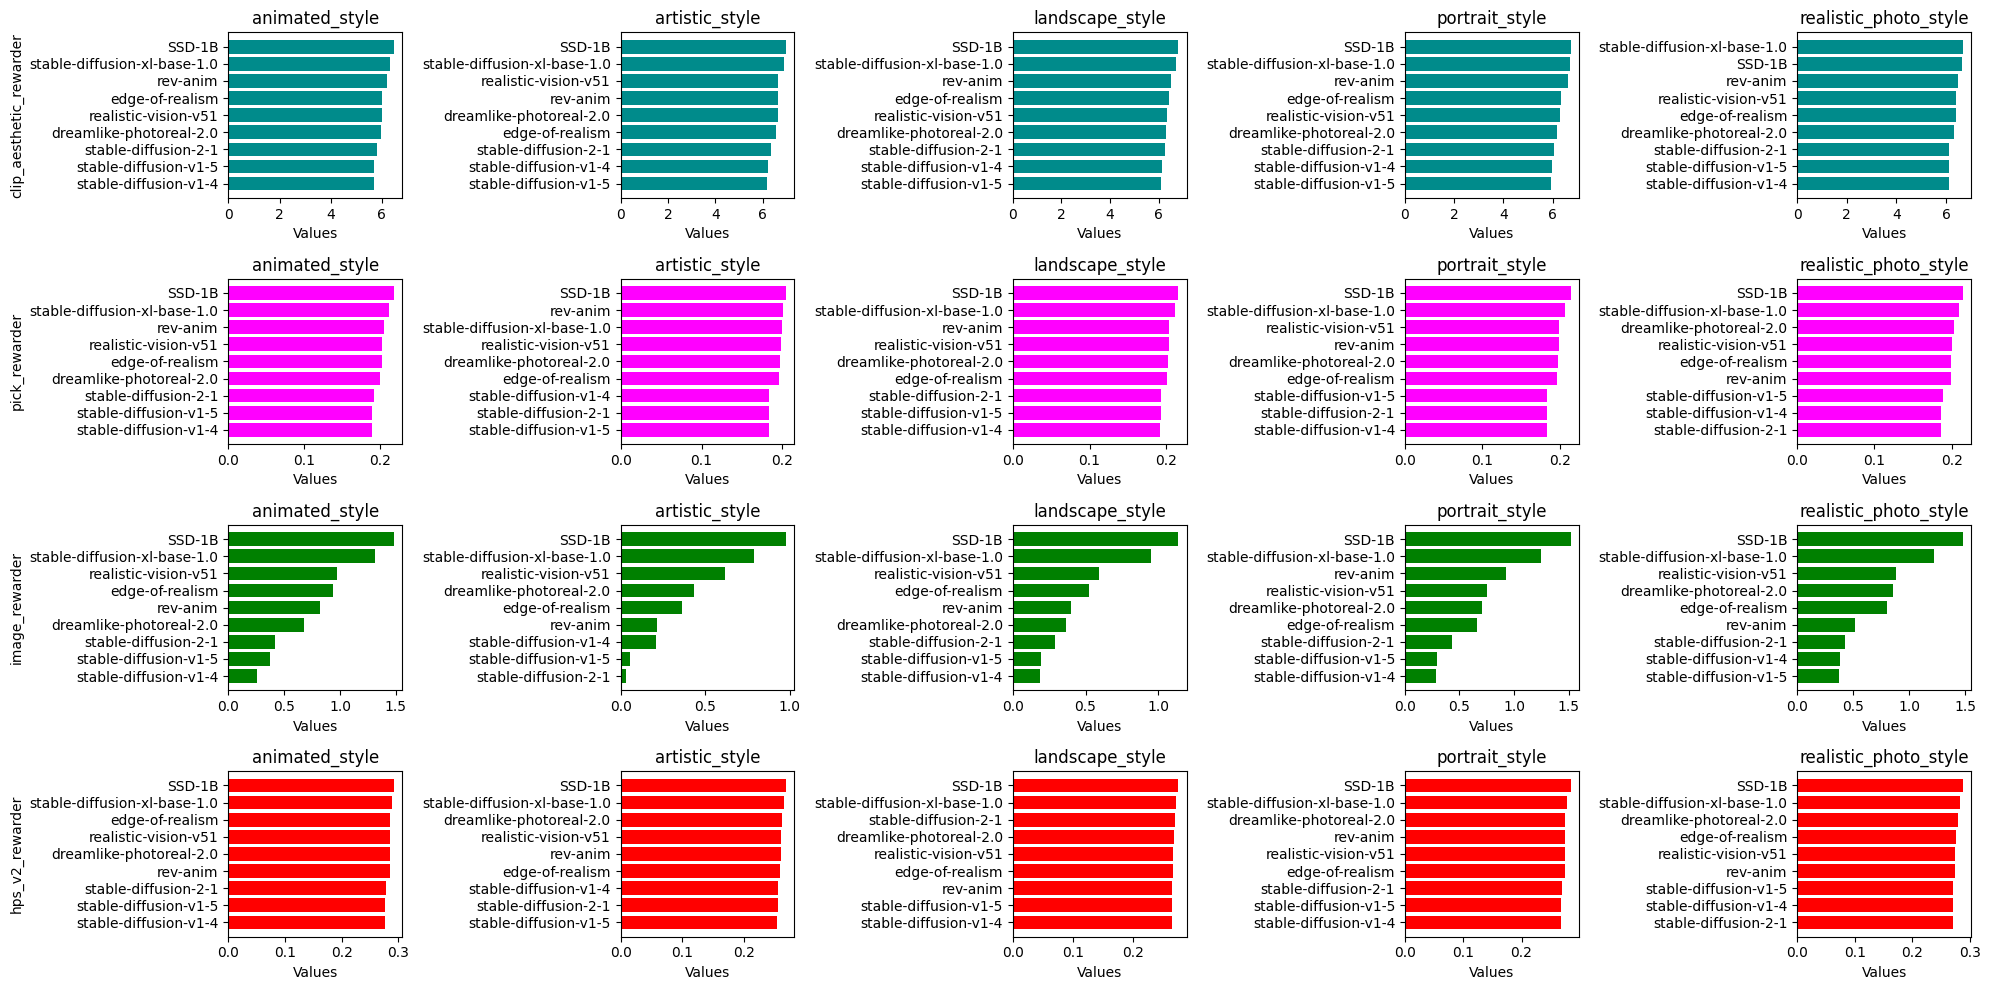

In [19]:
import matplotlib.pyplot as plt
barh_colors = ['darkcyan', 'magenta', 'green', 'red']
# Assuming you have a list of rewarders
rewarders = list(ds.individual_rewards[0].keys())

# Determine the number of rewarders and topics
num_rewarders = len(rewarders)
num_topics = len(ds['topic'].unique())

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rewarders, num_topics, figsize=(20, 10), sharex=False)

for i, rewarder in enumerate(rewarders):
    for j, topic_name in enumerate(ds['topic'].unique()):
        model_reward = {}
        for model_name, model_grp in ds[ds['topic'] == topic_name].groupby('model_type'):
            rewards = model_grp.individual_rewards.apply(lambda x: x[rewarder])
            model_reward[model_name] = rewards[:50].mean()
        sorted_data = dict(sorted(model_reward.items(), key=lambda item: item[1]))

        # Extract names and values for plotting
        names = list(sorted_data.keys())
        values = list(sorted_data.values())

        # Create a bar plot in the specified subplot
        axes[i, j].barh(names, values, color=barh_colors[i])
        axes[i, j].set_xlabel('Values')
        axes[i, 0].set_ylabel(rewarder)
        axes[i, j].set_title(topic_name)

# Adjust layout and spacing between subplots
plt.tight_layout()

# Display the combined figure
plt.show()
